In [72]:
using JuMP, Ipopt, Printf, Plots
using Images, QuartzImageIO, ImageView

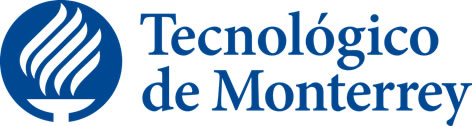

In [91]:
img = load("tec-logo.jpg")

# Alkylate Process Optimization

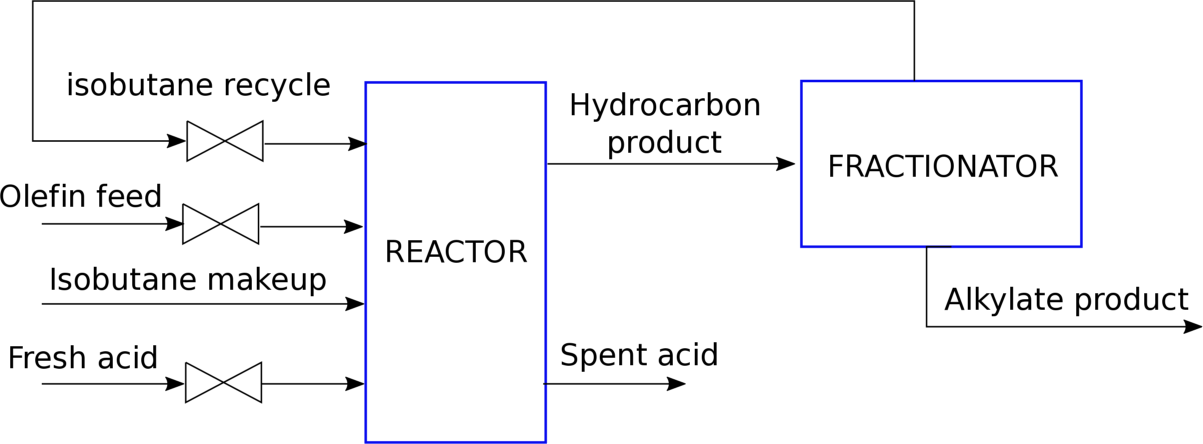

In [73]:
img = load("alkylate_plant.png")

In [74]:
alkylate_plant = Model(solver=IpoptSolver());

### Yield of alkylate ($F_{alk}$) is a function of both the olefin feed ($F_o$) as well as the recycle ratio ($R_{io}$):
$$ F_{alk} = F_o (1.12 + 0.13167 R_{io} - 0.0067 R_{io}^2) $$

In [75]:
@variable(alkylate_plant, 0 <= falk <= 5000, start = 4000);
@variable(alkylate_plant, 0 <= fo   <= 2000, start = 1000);
@variable(alkylate_plant, 3 <= rio  <= 12  , start = 10  );

@NLconstraint(alkylate_plant,c1, falk == fo*(1.12+0.13167*rio-0.0067*rio^2));

### Amount of isobutane makeup ($F_{im}$):
$$ F_{im} = 1.22F_{alk} - F_o $$

In [76]:
@variable(alkylate_plant, 0 <= fim <= 2000, start = 1000);

@NLconstraint(alkylate_plant,c2, fim == 1.22*falk - fo);

### The acid concentration ($C_{ac}$) is a function of the amount of acid ($F_{ac}$), the amount of alkylate ($F_{alk}$) and the acid dilution factor ($D_{ac}$). It should be stressed that the we have assumed that the acid has a default acid strength of 98:
$$  C_{ac} = \frac{98,000 F_{ac}}{1000 F_{ac}+F_{alk}D_{ac}} $$

In [77]:
@variable(alkylate_plant, 85  <= cac <= 93,  start = 90);
@variable(alkylate_plant, 0   <= fac <= 120, start = 100);
@variable(alkylate_plant, 1.2 <= dac <= 4,   start = 2);

@NLconstraint(alkylate_plant,c3, cac == 98000*fac/(1000*fac+falk*dac));

### Octane Number($O_N$):
$$ O_N = 86.35 + 1.098 R_{io} - 0.038R_{io}^2 + 0.325(C_{ac}-89) $$

In [78]:
@variable(alkylate_plant, 90 <= on <= 95,   start = 92);

@NLconstraint(alkylate_plant,c4, on == 86.35 + 1.098*rio - 0.038*rio^2 + 0.325*(cac-89));

### Definition of the isobutene recyled ratio ($R_{io}$) as a function of the amount of isobutane recyled ($F_{ir}$),  amount of isobutane makeup ($F_{im}$) and the amount of olefin fed ($F_o$):
$$ R_{io} = \frac{F_{ir}+F_{im}}{F_o} $$

In [79]:
@variable(alkylate_plant, 0 <= fir <= 16000,   start = 10000);

@NLconstraint(alkylate_plant,c5, rio*fo == fir+fim);

### The acid dilution factor ($D_{ac}$) is a linear function of the F4 Performance number ($P_N$):
$$ D_{ac} = 35.82 - 0.222 P_N $$


In [80]:
@variable(alkylate_plant, 145 <= pn <= 162, start = 150);

@NLconstraint(alkylate_plant,c6, dac == 35.82 - 0.222*pn);

### The F4 Performance number ($P_N$) is a linear function of the octane number ($O_N$):
$$ P_N = 3O_N - 133$$

In [81]:
@NLconstraint(alkylate_plant,c7, pn == 3*on - 133 );

### The objective function ($\Omega$) represents the economic profit given as the selling price of the akylate minus the cost of all raw materials:
$$ \Omega = c_1 F_{alk} O_N - c_2 F_o - c_3 F_{ir} - c_4 F_{ac} - c_5 F_{im} $$
### where $c_i,\, i=1,...,5$ stand for the respective costs.

In [82]:
c1 = 0.063  ; # alkylate selling price [$/octane barrel]
c2 = 5.04   ; # olefin feed cost [$/barrel] 
c3 = 0.035  ; # isobutae recycle cost [$/barrel]
c4 = 10     ; # acid cost [$/thousand pounds]
c5 = 3.36   ; # isobutane makeup cost [$/barrel]

@NLobjective(alkylate_plant, Max, c1*falk*on - c2*fo - c3*fir - c4*fac - c5*fim) ;

In [83]:
status_alkylate_plant = solve(alkylate_plant);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       21
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       16

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equ

In [92]:
println("Objective function value      = ", getobjectivevalue(alkylate_plant))
@printf " Olefin fed [BPD]             : %f\n" getvalue(fo)
@printf " Isobutene recycled [BPD]     : %f\n" getvalue(fir)
@printf " Acid fed [BPD]               : %f\n" getvalue(fac)
@printf " Alkylate yield [BPD]         : %f\n" getvalue(falk)
@printf " Isobutane makeup [BPD]       : %f\n" getvalue(fim)
@printf " Acid strength []             : %f\n" getvalue(cac)
@printf " Octane number []             : %f\n" getvalue(on)
@printf " Isobutane to olefin ratio [] : %f\n" getvalue(dac)
@printf " F4 Performance number []     : %f\n" getvalue(falk)

Objective function value      = 1154.433163736584
 Olefin fed [BPD]             : 1734.409800
 Isobutene recycled [BPD]     : 16000.000000
 Acid fed [BPD]               : 98.405327
 Alkylate yield [BPD]         : 3060.991656
 Isobutane makeup [BPD]       : 2000.000000
 Acid strength []             : 90.591635
 Octane number []             : 94.169669
 Isobutane to olefin ratio [] : 2.629001
 F4 Performance number []     : 3060.991656
